# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Understanding the key drivers of price for used cars requires the application of various data science techniques, structured into a cohesive analytic narrative to ensure rigor and actionable insights.

#### First, data preprocessing steps should take place to get the data ready for analysis and modeling.  Key steps include:
- Treating null values
- Converting categorical values into numerical forms
- Normalizing the numerical values

#### Second, we should deep dive into feature engineering to understand which features are relevant for used car pricing.  Key steps include:
- Correlational analysis
- Visualization of key trends
- Principal component analysis

#### Third, model building, selection, and regularization steps should provide key insights on the factors that drive differential pricing for used cars.  Key steps include:
- Linear regression
- Cross-validation
- Regularization

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
set_config(display="diagram")

In [237]:
df = pd.read_csv('data/vehicles.csv')

In [177]:
df.tail()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy
426879,7301591129,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,NaN,coupe,NaN,wy


#### There are 31,351 cars older than 2001.  We will remove these cars from the data, since some consumers price very old cars (e.g. classic muscle cars) for their collector values, which is an entirely different and unique consumer psyche.


In [178]:
pd.DataFrame(df['year'].value_counts().sort_values()).iloc[:94,:].sum()

year    31351
dtype: int64

<Axes: xlabel='index'>

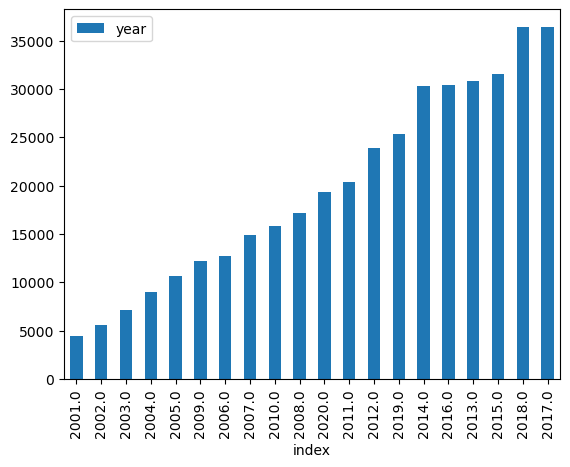

In [179]:
pd.DataFrame(df['year'].value_counts().sort_values()).iloc[94:,:].reset_index().plot(kind = 'bar', x = 'index', y = 'year')

#### The distribution of car manufactuers in the data set seems fair.  Simplify this into mass-market v. premium

<Axes: >

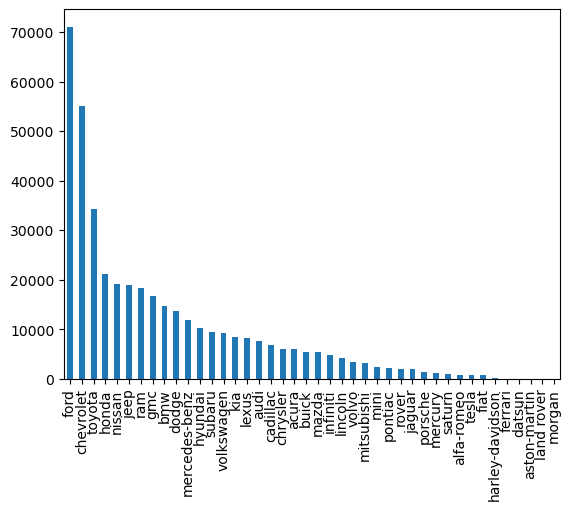

In [180]:
df['manufacturer'].value_counts().plot(kind = 'bar')

In [181]:
df['manufacturer']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
426875      nissan
426876       volvo
426877    cadillac
426878       lexus
426879         bmw
Name: manufacturer, Length: 426880, dtype: object

#### The distribution of car conditions also seems fair.  Remove salvage and new, since they are typically not considered used cars.

<Axes: >

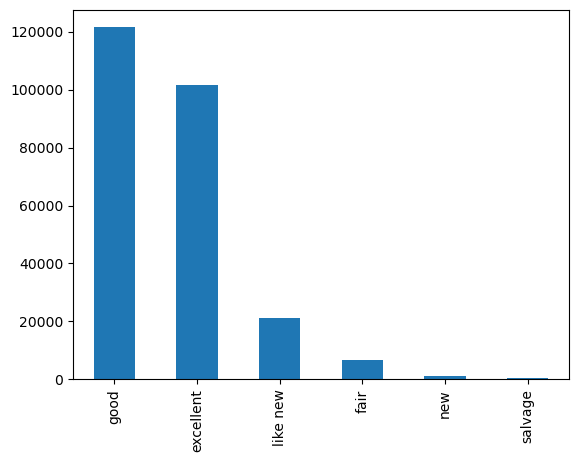

In [182]:
df['condition'].value_counts().plot(kind = 'bar')

#### A vast majority of cars have 4, 6, or 8 cylinders.  We will remove the remainder, given their extremely small sample sizes

<Axes: >

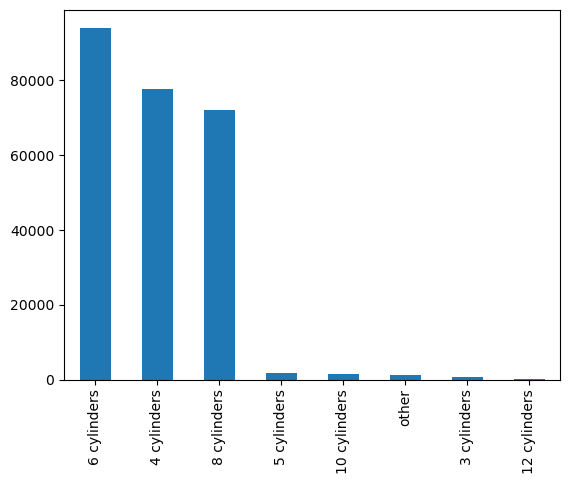

In [183]:
df['cylinders'].value_counts().plot(kind = 'bar')

#### Distribution of fuel types also seems fair.  For modeling purposes, make this column into a binary gas v. non-gas.

<Axes: >

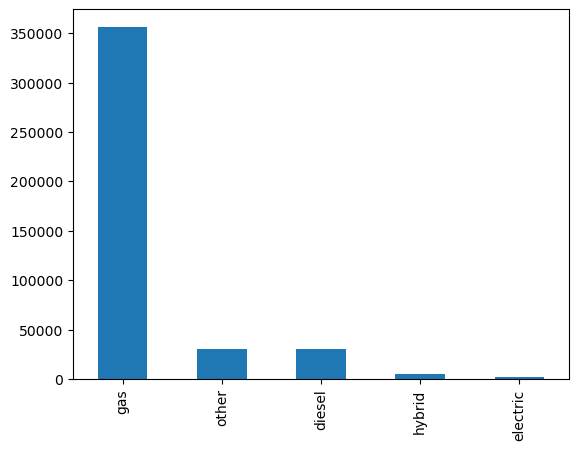

In [184]:
df['fuel'].value_counts().plot(kind = 'bar')

#### Distribution of odometer ranges seems fair

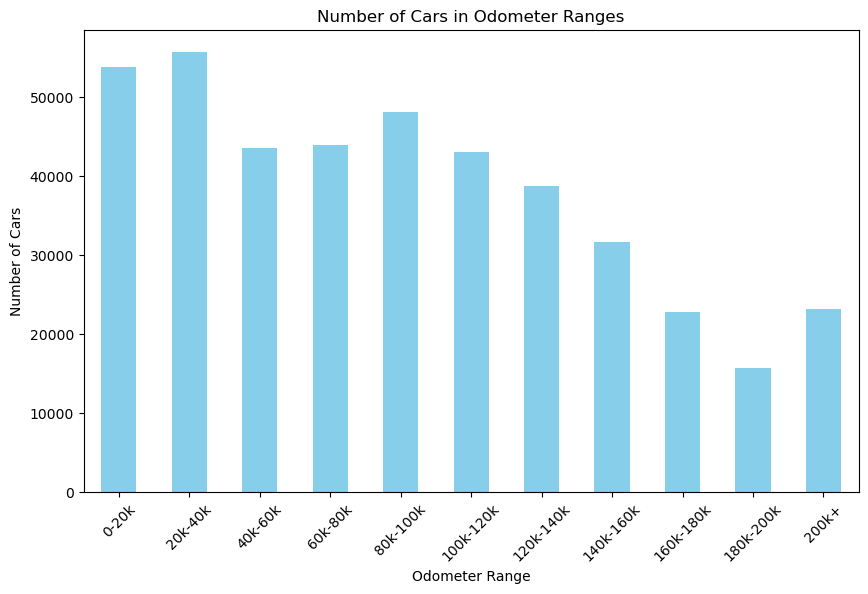

In [185]:
odometer_ranges = [0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, float('inf')]
labels = ['0-20k', '20k-40k', '40k-60k', '60k-80k', '80k-100k', '100k-120k', '120k-140k', '140k-160k', '160k-180k', '180k-200k', '200k+']
df['odometer_range'] = pd.cut(df['odometer'], bins=odometer_ranges, labels=labels)
price_range_counts = df['odometer_range'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
price_range_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Odometer Range')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Odometer Ranges')
plt.xticks(rotation=45)
plt.show()

#### We will also remove the cars without clean titles, as their pricing will likely vary drastically case by case

<Axes: >

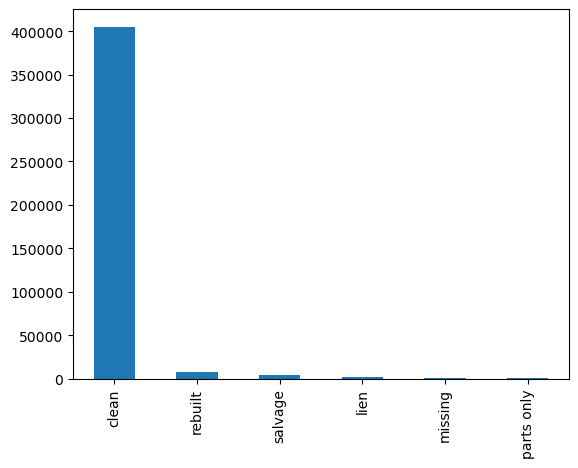

In [186]:
df['title_status'].value_counts().plot(kind = 'bar')

#### Distribution of transmission types seems fair

<Axes: >

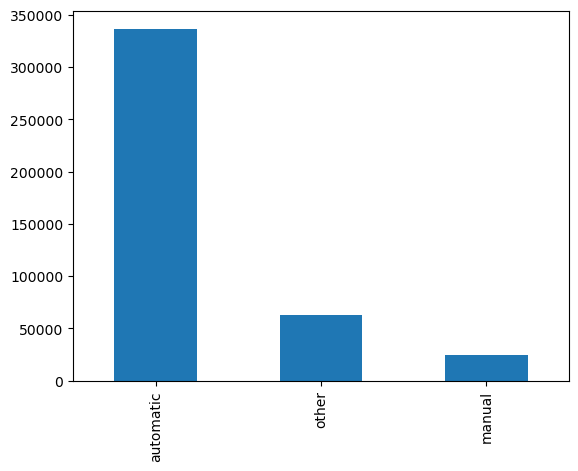

In [187]:
df['transmission'].value_counts().plot(kind = 'bar')

#### Distribution of drive types seems fair

<Axes: >

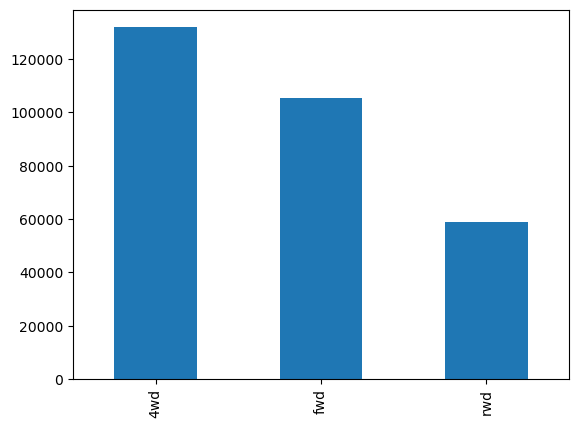

In [188]:
df['drive'].value_counts().plot(kind = 'bar')

#### Distribution of vehicle sizes seems fair

<Axes: >

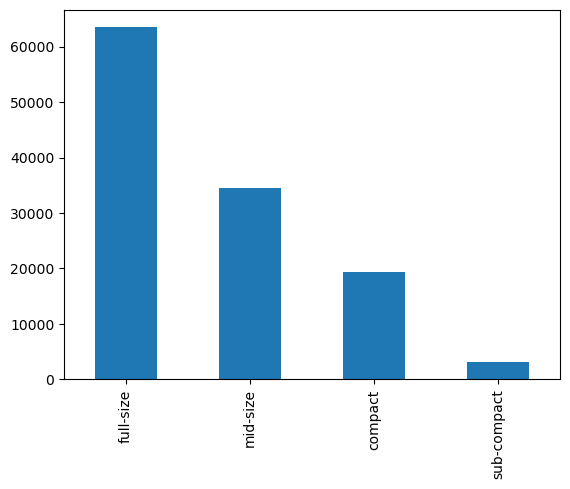

In [189]:
df['size'].value_counts().plot(kind = 'bar')

#### Distribution of vehicle types seems fair.  Remove bus and offroad; why are they here?  Bucket the small types together.

<Axes: >

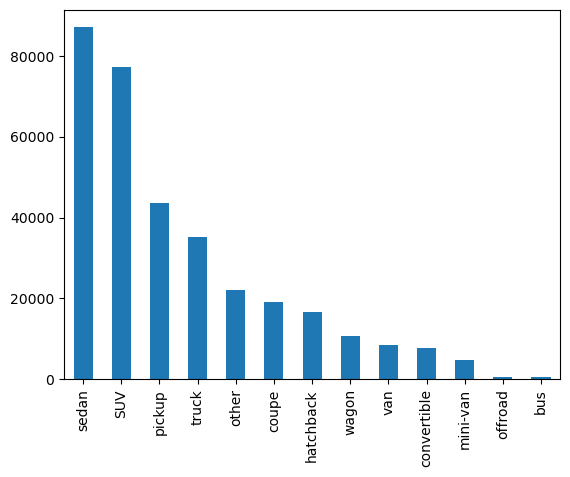

In [190]:
df['type'].value_counts().plot(kind = 'bar')

#### Distribution of vehicle colors seems fair.  Bucket green, brown, yellow, orange, purple, and custom into 'other' bucket

<Axes: >

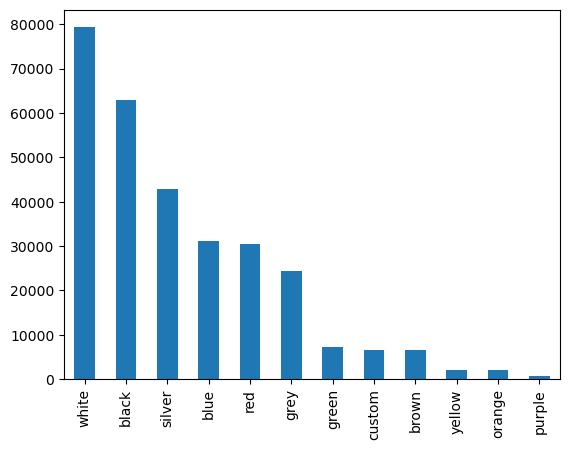

In [191]:
df['paint_color'].value_counts().plot(kind = 'bar')

#### Distribution of states seems fair

<Axes: >

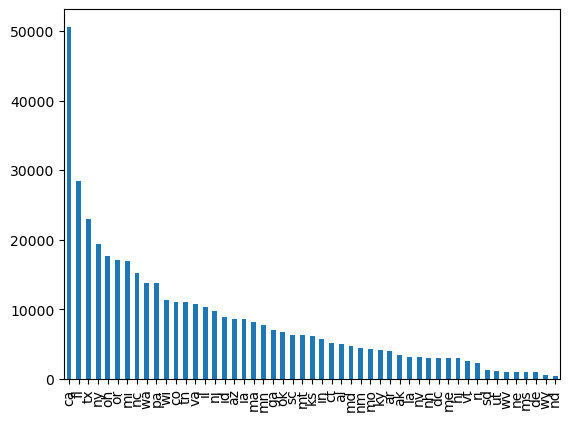

In [192]:
df['state'].value_counts().plot(kind = 'bar')

#### Distribution of vehicle prices seems fair

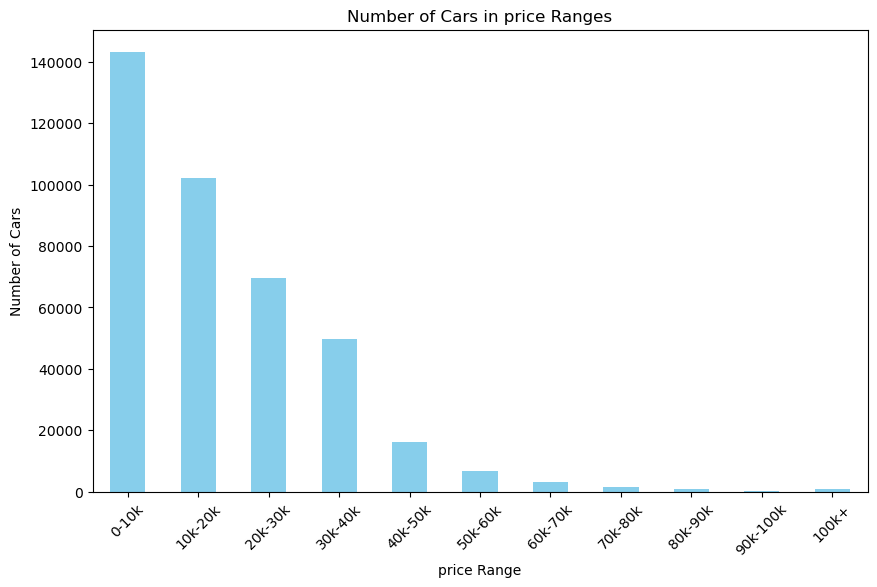

In [193]:
price_ranges = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, float('inf')]
labels = ['0-10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k', '50k-60k', '60k-70k', '70k-80k', '80k-90k', '90k-100k', '100k+']
df['price_range'] = pd.cut(df['price'], bins=price_ranges, labels=labels)
price_range_counts = df['price_range'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
price_range_counts.plot(kind='bar', color='skyblue')
plt.xlabel('price Range')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in price Ranges')
plt.xticks(rotation=45)
plt.show()

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In addition to filtering the data based on the year, title status, and cylinders, we will also remove useless columns, such as id, region, VIN and state.  We will also remove model, despite it being a highly informative column.  Turning this into a series of dummy variables is likely ineffective given the number of unique models in the data set.  Also, we will remove size, given a majority of data entries in this column are NaN.

In [194]:
df

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,odometer_range,price_range
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,0-10k
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,10k-20k
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,20k-30k
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,0-10k
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,0-10k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy,20k-40k,20k-30k
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy,0-20k,30k-40k
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy,0-20k,30k-40k
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy,20k-40k,20k-30k


In [238]:
df_clean = df[
    (df['year'] >= 2001)
    & (df['title_status'] == 'clean')
    & (df['cylinders'].isin(['4 cylinders','6 cylinders','8 cylinders']))
][['price','year','manufacturer','condition','cylinders','fuel','odometer','transmission','drive','type','paint_color']].dropna(axis = 0)

In [239]:
fuel_dict = {'gas':1, 'other':0, 'diesel':0, 'hybrid':0, 'electric':0}
df_clean['fuel'] = df_clean['fuel'].replace(fuel_dict)

In [240]:
manufacturer_dict = {    
'ford':'mass-market',           
'chevrolet':'mass-market',      
'toyota':'mass-market',         
'honda':'mass-market',          
'nissan':'mass-market',         
'jeep':'premium',           
'ram':'mass-market',            
'gmc':'mass-market',            
'bmw':'premium',            
'dodge':'mass-market',          
'mercedes-benz':'premium',  
'hyundai':'mass-market',        
'subaru':'premium',         
'volkswagen':'premium',     
'kia':'mass-market',            
'lexus':'premium',          
'audi':'premium',           
'cadillac':'premium',       
'chrysler':'mass-market',       
'acura':'premium',          
'buick':'premium',          
'mazda':'mass-market',          
'infiniti':'premium',       
'lincoln':'premium',         
'volvo':'premium',          
'mitsubishi':'mass-market',     
'mini':'premium',           
'pontiac':'mass-market',        
'rover':'premium',          
'jaguar':'premium',         
'porsche':'premium',        
'mercury':'mass-market',        
'saturn':'mass-market',         
'alfa-romeo':'premium',     
'tesla':'premium',          
'fiat':'mass-market',           
'harley-davidson':'premium',
'ferrari':'premium',        
'datsun':'mass-market',         
'aston-martin':'premium',   
'land rover':'premium',     
'morgan':'premium'}

df_clean['manufacturer'] = df_clean['manufacturer'].replace(manufacturer_dict)

In [241]:
paint_color_dict = {'green':'other','custom':'other','brown':'other','yellow':'other','orange':'other','purple':'other'}

df_clean['paint_color'] = df_clean['paint_color'].replace(paint_color_dict)

In [257]:
type_dict = {'coupe':'coupe/convertable',
'hatchback':'hatchback/wagon',
'other':'other',
'van':'van/mini-van',
'wagon':'hatchback/wagon',
'mini-van':'van/mini-van',
'convertible':'coupe/convertable'}

df_clean['type'] = df_clean['type'].replace(type_dict)

In [242]:
df_clean = df_clean[(df_clean['condition'] != 'salvage') & (df['condition'] != 'new')]

C:\Users\hanwo\AppData\Local\Temp\ipykernel_13372\3929955639.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[(df_clean['condition'] != 'salvage') & (df['condition'] != 'new')]


In [243]:
df_clean = df_clean[(df_clean['type'] != 'bus') & (df['type'] != 'offroad')]

C:\Users\hanwo\AppData\Local\Temp\ipykernel_13372\175958237.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[(df_clean['type'] != 'bus') & (df['type'] != 'offroad')]


In [244]:
df_clean

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
31,15000,2013.0,mass-market,excellent,6 cylinders,1,128000.0,automatic,rwd,truck,black
32,27990,2012.0,mass-market,good,8 cylinders,1,68696.0,other,4wd,pickup,black
33,34590,2016.0,mass-market,good,6 cylinders,1,29499.0,other,4wd,pickup,silver
34,35000,2019.0,mass-market,excellent,6 cylinders,1,43000.0,automatic,4wd,truck,grey
35,29990,2016.0,mass-market,good,6 cylinders,1,17302.0,other,4wd,pickup,red
...,...,...,...,...,...,...,...,...,...,...,...
426859,48590,2020.0,premium,good,6 cylinders,1,7701.0,other,fwd,other,black
426860,39990,2017.0,premium,good,8 cylinders,1,41664.0,automatic,4wd,other,black
426866,32990,2016.0,premium,good,8 cylinders,1,55612.0,automatic,rwd,other,black
426874,33590,2018.0,premium,good,6 cylinders,1,30814.0,automatic,rwd,sedan,white


In [245]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97322 entries, 31 to 426878
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         97322 non-null  int64  
 1   year          97322 non-null  float64
 2   manufacturer  97322 non-null  object 
 3   condition     97322 non-null  object 
 4   cylinders     97322 non-null  object 
 5   fuel          97322 non-null  int64  
 6   odometer      97322 non-null  float64
 7   transmission  97322 non-null  object 
 8   drive         97322 non-null  object 
 9   type          97322 non-null  object 
 10  paint_color   97322 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 8.9+ MB


In [258]:
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(df_clean[['manufacturer', 'condition','cylinders','transmission','drive','type','paint_color']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['manufacturer', 'condition','cylinders','transmission','drive','type','paint_color']))

df_final = df_clean[['price','year','fuel','odometer']].reset_index().join(encoded_df)
df_final = df_final.drop(['index'], axis = 1)
df_final

C:\Users\hanwo\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,price,year,fuel,odometer,manufacturer_mass-market,manufacturer_premium,condition_excellent,condition_fair,condition_good,condition_like new,...,type_sedan,type_truck,type_van/mini-van,paint_color_black,paint_color_blue,paint_color_grey,paint_color_other,paint_color_red,paint_color_silver,paint_color_white
0,15000,2013.0,1,128000.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,27990,2012.0,1,68696.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34590,2016.0,1,29499.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,35000,2019.0,1,43000.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,29990,2016.0,1,17302.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97317,48590,2020.0,1,7701.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
97318,39990,2017.0,1,41664.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
97319,32990,2016.0,1,55612.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
97320,33590,2018.0,1,30814.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [259]:
df_final_X = df_final.drop(['price'], axis = 1)
df_final_y = df_final['price']

In [260]:
X_train, X_test, y_train, y_test = train_test_split(df_final_X, df_final_y, test_size = 0.3, random_state = 42)

In [261]:
X_train

,year,fuel,odometer,manufacturer_mass-market,manufacturer_premium,condition_excellent,condition_fair,condition_good,condition_like new,cylinders_4 cylinders,...,type_sedan,type_truck,type_van/mini-van,paint_color_black,paint_color_blue,paint_color_grey,paint_color_other,paint_color_red,paint_color_silver,paint_color_white
37981,2012.0,1,43182.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
87107,2015.0,1,144000.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18818,2012.0,1,134295.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
35149,2007.0,1,289055.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58349,2008.0,1,18369.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,2008.0,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
54886,2015.0,1,116600.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
76820,2007.0,1,129900.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
860,2020.0,1,728.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Sequential Feature Selector - Linear Regression

In [267]:
selector_pipe = Pipeline([('selector', SequentialFeatureSelector(LinearRegression())),
                         ('model', LinearRegression())])
param_dict = {'selector__n_features_to_select': [3,4,5,7,10]}

selector_grid = GridSearchCV(selector_pipe, param_grid=param_dict)

selector_grid.fit(X_train, y_train)

train_preds = selector_grid.predict(X_train)
test_preds = selector_grid.predict(X_test)

#### Ridge Regression

In [263]:
ridge_pipe = Pipeline([('scaler', StandardScaler()), 
                      ('ridge', Ridge())])
ridge_param_dict = {'ridge__alpha': np.logspace(0, 10, 20)}

ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict)

ridge_grid.fit(X_train, y_train)

ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### Both models yield similar MSEs

In [264]:
selector_train_mse = mean_squared_error(y_train, train_preds)
selector_test_mse = mean_squared_error(y_test, test_preds)

print(f'Train MSE: {selector_train_mse}')
print(f'Test MSE: {selector_test_mse}')

Train MSE: 205256912354602.78
Test MSE: 13988631258.558874


In [265]:
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)

print(f'Train MSE: {ridge_train_mse}')
print(f'Test MSE: {ridge_test_mse}')

Train MSE: 205256629093463.38
Test MSE: 13811912982.36606


#### Which drivers were selected in the Sequential Feature Selector?  SFS chose condition_fair, transmission_manual and type_other variables as the most influential drivers.  Linear regression tends to be heavily influenced by these binary variables.

In [269]:
best_estimator = selector_grid.best_estimator_
best_selector = best_estimator.named_steps['selector']
best_model = selector_grid.best_estimator_.named_steps['model']
feature_names = X_train.columns[best_selector.get_support()]
coefs = best_model.coef_

print(best_estimator)
print(f'Features from best selector: {feature_names}.')
print('Coefficient values: ')
print('===================')
pd.DataFrame([coefs.T], columns = feature_names, index = ['model'])

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=3)),
                ('model', LinearRegression())])
Features from best selector: Index(['condition_fair', 'transmission_manual', 'type_other'], dtype='object').
Coefficient values: 


,condition_fair,transmission_manual,type_other
model,-69383.767089,-63283.91846,-48991.110192


#### Which drivers were weighted more heavily in the Ridge Regression?  The numeric comparison of coefficients shows that having more cylinders, being a pickup type, and the color silver are the most impactful variables in price calculation.  However, we should note that these are dummy variables with only 1 or 0 as possible values.  The variable 'year', for example, can have a wider range of values and certainly can have bigger overall impact.

In [278]:
best_ridge_model = ridge_grid.best_estimator_.named_steps['ridge']

coefficients = best_ridge_model.coef_
column_names = X_train.columns  # Assuming X_train is a DataFrame

coefficients_df = pd.DataFrame({'Variable': column_names, 'Coefficient': coefficients})
coefficients_df

,Variable,Coefficient
0,year,-132.607974
1,fuel,42.883618
2,odometer,45.160300
3,manufacturer_mass-market,97.238268
4,manufacturer_premium,-97.238268
5,condition_excellent,158.990101
6,condition_fair,-29.840393
7,condition_good,-127.872456
8,condition_like new,-38.633103
9,cylinders_4 cylinders,-126.622161


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Context: Understanding customer psychology in the used car market is a complex problem.  It involves deep consideration for numerous known facts about used cars and ultimately what customers value the most (and therefore are willing to pay more).

Approach: A data-driven approach to answer this question relies on regression modeling, which will tell us which facts have the biggest impact on used car pricing.  We will investigate two regression methodologies:
1. Linear regression with sequential feature selection: This will help us identify n most impactful used car facts on pricing
2. Ridge regression: This will help us understand the relative weight of each fact when it come to used car pricing

Data: We looked at a dataset of ~97K used cars.  We filtered out the following to ensure that we are modeling on the most mainstream used car market:
1. Manufactured before te year 2000
2. Any car that does not have clean title
3. Atypical cylinder types (i.e. not 4, 6, or 8 cylinders)
4. Bus or offroad vehicles
5. Salvage or new vehicles

Analysis: To generate the most predictive regression models, we used a technique called GridSearchCV to try a number of model configurations and selected the best model.  
1. Linear regression with sequential feature selection: We built a model with 3 variables - used car condition, transmission type, and vehicle type.  This does not pass a "smell test," as it doesn not include usual suspects like year.  This is likely the outcome of binary variables having outsized impact on the sequential feature selection process.
2. Ridge regression: This doesn't remove any variables from the model; rather, it places different weights to place more emphasis on key variables.  The result shows that 1) 8-cylinder pickup cars are more expensive, 2) the color silver is preferred over all the other colors, 3) when considering the range of values for the year variable, year is also one of the most important factors in pricing

Takeaways: Using different modeling techniques will typically produce different results.  Hence, it's important to consider them on balance, and we can say customers are willing to pay more for the following:
1. Newer cars
2. Better condition
3. Automatic transmission
4. Pickup trucks
5. Silver color